## Energy usage prediction: a time-series modeling 

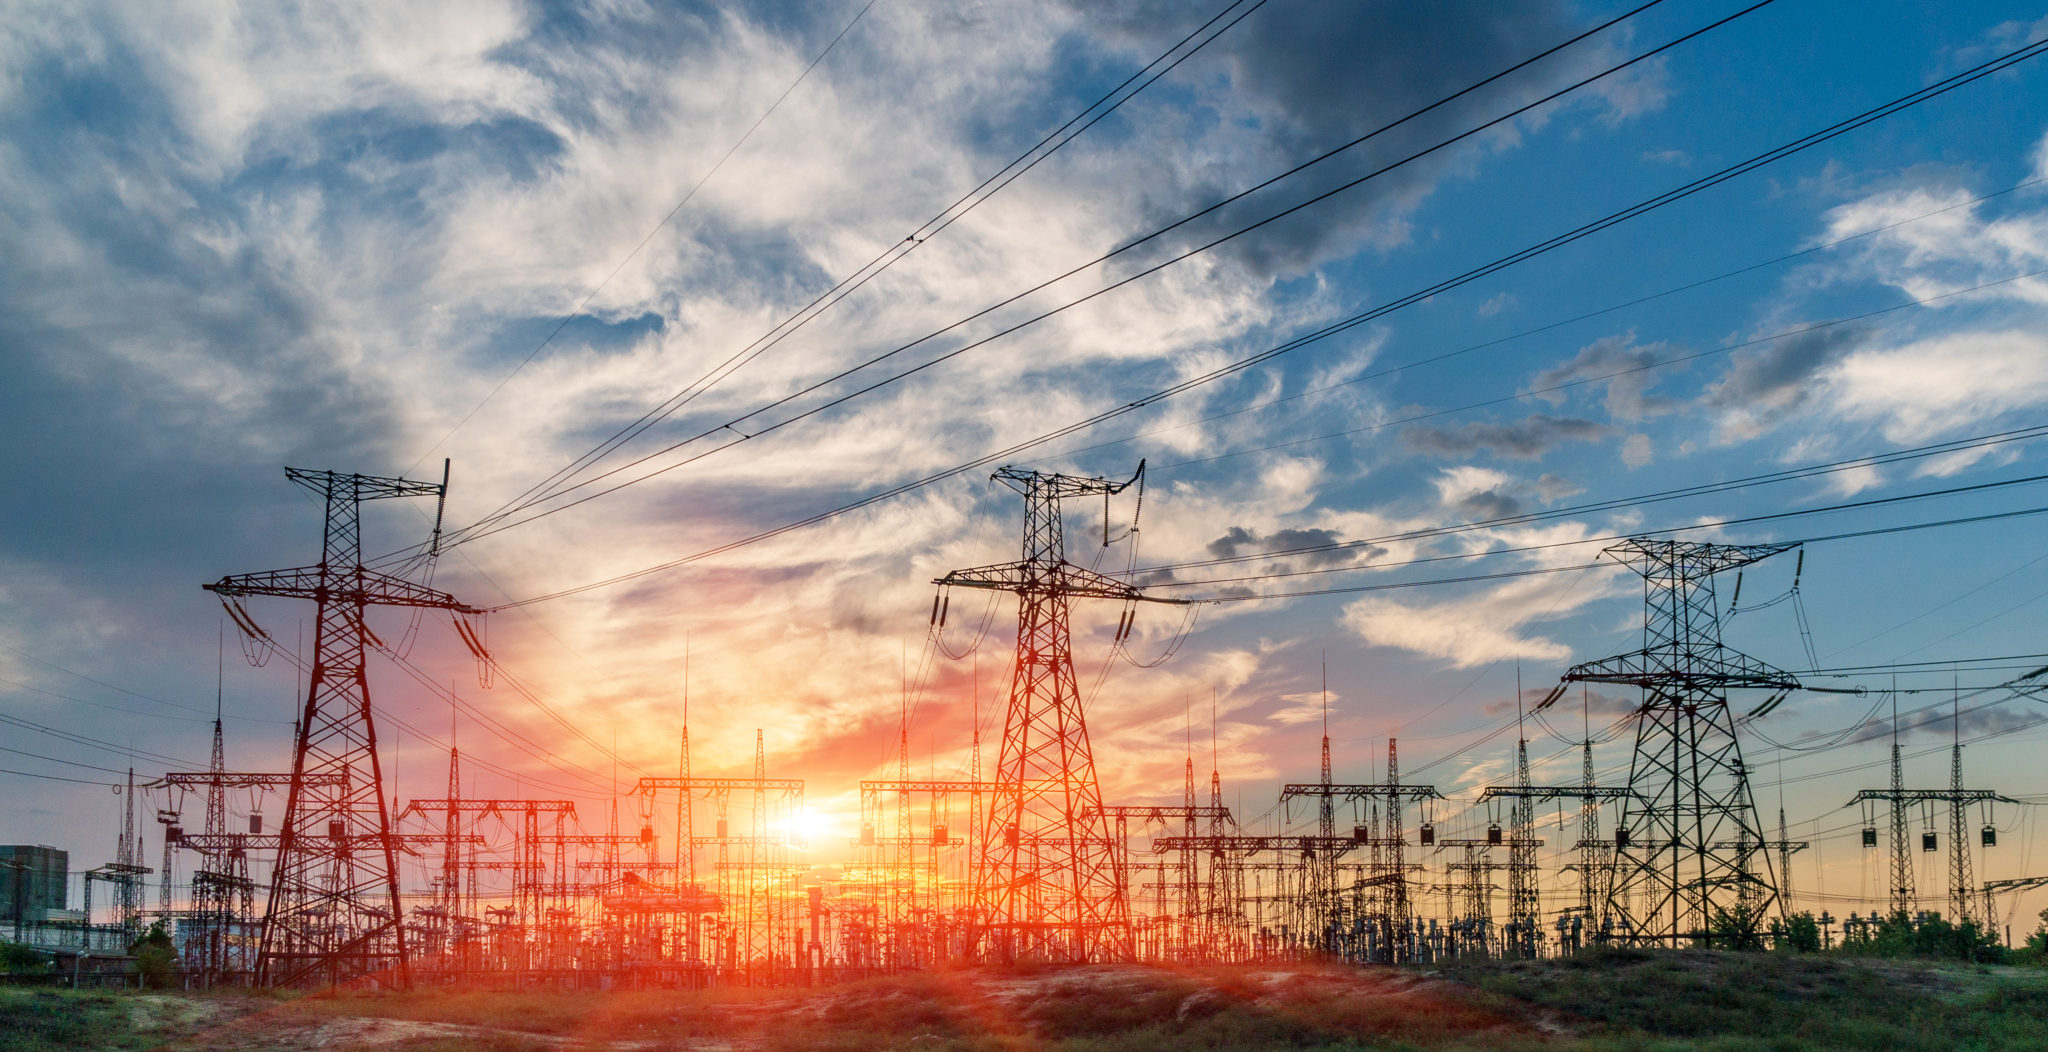

In this notebook we will predict energy consumption by using XGBOOST. The data we will be using is hourly energy consumption and can be found [here.](https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-xgboost/data)

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')


In [89]:
data= pd.read_csv('AEP_hourly.csv', parse_dates=[0])


In [90]:
data.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [91]:
data.duplicated().sum()

0

In [92]:
data['Datetime'] = pd.to_datetime(data['Datetime'])
data = data.set_index('Datetime')

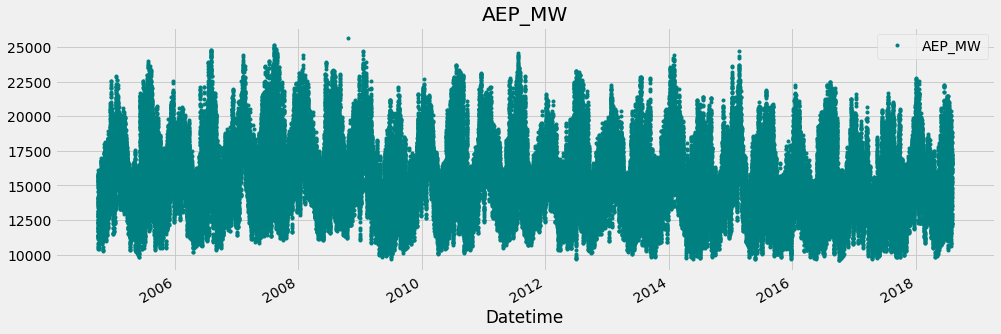

In [93]:
colors = ['darkblue', 'teal', 'coral', 'crimson', 'orchid', 'magenta']
#colors = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]

_ = data.plot(style='.', lw=0.2,  figsize=(15,5), color=colors[1], title='AEP_MW')

In order to model the data, we first begin by extracting features from the data. More specifically we got _day of the week_, _month_, _year_ and similar features from the data. Then we define X and y arrays. 

The next step is to split the data to train and test sets.

In [94]:
data['date'] = data.index
data['hour'] = data['date'].dt.hour
data['dayofweek'] = data['date'].dt.dayofweek
data['quarter'] = data['date'].dt.quarter
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dayofyear'] = data['date'].dt.dayofyear
data['dayofmonth'] = data['date'].dt.day
data['weekofyear'] = data['date'].dt.weekofyear

<ipython-input-94-de864a72115e>:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data['weekofyear'] = data['date'].dt.weekofyear


In [95]:
split_date = '01-Jan-2015'
AEP_train = data.loc[data.index <= split_date].copy()
AEP_test = data.loc[data.index > split_date].copy()

In [96]:
X = data[['date', 'hour','dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear']]
X = X.set_index('date')
y = data['AEP_MW']

In [97]:
# Let's split the data

split_date = '01-Jan-2015'
X_train = X.loc[X.index <= split_date].copy()
X_test = X.loc[X.index > split_date].copy()
y_train = y.loc[y.index <= split_date].copy()
y_test = y.loc[y.index > split_date].copy()

Now we are ready to train a model on the training data. Let's initiate a regressor and fit the model.

In [98]:
model = xgb.XGBRegressor(n_estimators=1000)
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True) 

[0]	validation_0-rmse:11222.90820	validation_1-rmse:10311.86719
[1]	validation_0-rmse:7931.27978	validation_1-rmse:7034.17432
[2]	validation_0-rmse:5650.32129	validation_1-rmse:4850.94092
[3]	validation_0-rmse:4082.42188	validation_1-rmse:3455.44238
[4]	validation_0-rmse:3020.19092	validation_1-rmse:2532.72632
[5]	validation_0-rmse:2314.29126	validation_1-rmse:1984.89551
[6]	validation_0-rmse:1857.17529	validation_1-rmse:1728.25232
[7]	validation_0-rmse:1586.59973	validation_1-rmse:1614.13696
[8]	validation_0-rmse:1401.89014	validation_1-rmse:1616.38062
[9]	validation_0-rmse:1307.86462	validation_1-rmse:1613.73144
[10]	validation_0-rmse:1226.42993	validation_1-rmse:1631.92505
[11]	validation_0-rmse:1177.13599	validation_1-rmse:1645.60010
[12]	validation_0-rmse:1154.63928	validation_1-rmse:1657.50928
[13]	validation_0-rmse:1122.59436	validation_1-rmse:1667.47022
[14]	validation_0-rmse:1110.03821	validation_1-rmse:1670.05701
[15]	validation_0-rmse:1090.37134	validation_1-rmse:1678.60840


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Feature Importance Analysis

Let's look at the feature importance plot.

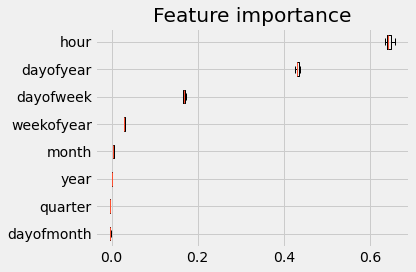

In [100]:
from sklearn.inspection import permutation_importance
result = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx]
)
ax.set_title("Feature importance")
fig.tight_layout()
plt.show()

We can see that the hour of the day is the most infuluential factor.

In [120]:
data.head()

,AEP_MW,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,,
2004-12-31 01:00:00,13478.0,2004-12-31 01:00:00,1,4,4,12,2004,366,31,53
2004-12-31 02:00:00,12865.0,2004-12-31 02:00:00,2,4,4,12,2004,366,31,53
2004-12-31 03:00:00,12577.0,2004-12-31 03:00:00,3,4,4,12,2004,366,31,53
2004-12-31 04:00:00,12517.0,2004-12-31 04:00:00,4,4,4,12,2004,366,31,53
2004-12-31 05:00:00,12670.0,2004-12-31 05:00:00,5,4,4,12,2004,366,31,53


## Hourly Usage

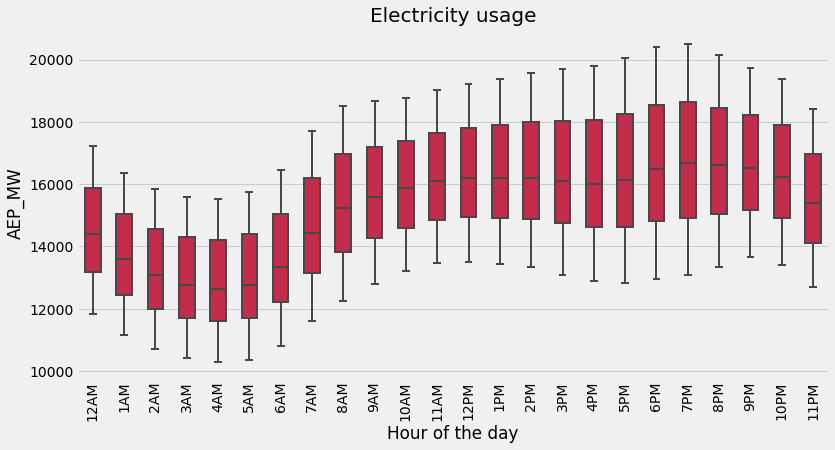

In [150]:

fig, ax = plt.subplots(figsize=(12,6))


sns.boxplot(y='AEP_MW', x='hour', data=data, showfliers = False, color=colors[3], width=0.5, fliersize=2, linewidth=2, whis=0.5)
ax.set_title('Electricity usage', fontsize = 20, loc='center')
ax.set(xlabel='Hour of the day')
ax.set_xticklabels(['12AM', '1AM', '2AM', '3AM', '4AM', '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM', '12PM',
                      '1PM', '2PM', '3PM', '4PM', '5PM', '6PM', '7PM', '8PM', '9PM', '10PM', '11PM'], rotation=90)
print('')


## Predict 

Now we use our trained model to predict the test data

In [102]:
AEP_test['Prediction'] = model.predict(X_test)
AEP_all = pd.concat([AEP_test, AEP_train], sort=False)

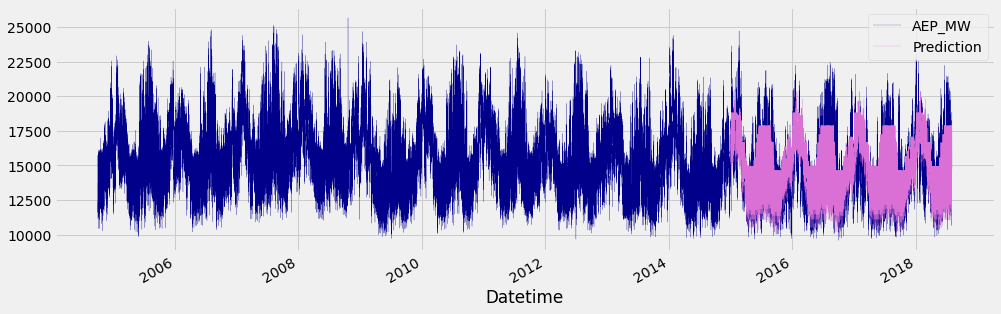

In [103]:
_ = AEP_all[['AEP_MW','Prediction']].plot(figsize=(15, 5), color=[colors[0], colors[4]], lw=0.2)

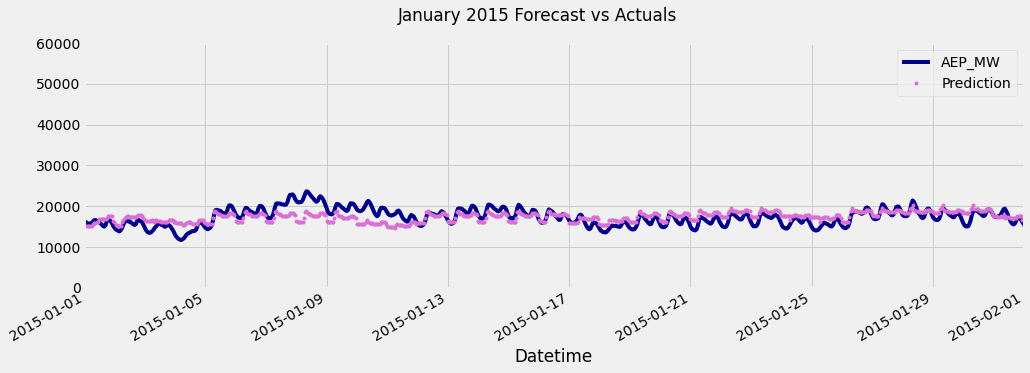

In [104]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = AEP_all[['AEP_MW', 'Prediction']].plot(ax=ax, style=['-','.'], color=[colors[0], colors[4]])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

Let's look at the error.

In [105]:
mean_squared_error(y_true=AEP_test['AEP_MW'], y_pred=AEP_test['Prediction'])


2604129.5553274993

In [106]:
mean_absolute_error(y_true=AEP_test['AEP_MW'], y_pred=AEP_test['Prediction'])

1237.3640072963715

In [107]:
y_true, y_pred = np.array(AEP_test['AEP_MW']), np.array(AEP_test['Prediction'])
mean_absolute_percentage_error = np.mean(np.abs((y_true - y_pred) / y_true))*100
print('The percentage of absolute error is {}'.format(mean_absolute_percentage_error))

The percentage of absolute error is 8.270429862369676


In [108]:
AEP_test.head()

,AEP_MW,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Prediction
Datetime,,,,,,,,,,,
2015-12-31 01:00:00,12415.0,2015-12-31 01:00:00,1,3,4,12,2015,365,31,53,14086.010742
2015-12-31 02:00:00,12087.0,2015-12-31 02:00:00,2,3,4,12,2015,365,31,53,13910.890625
2015-12-31 03:00:00,12010.0,2015-12-31 03:00:00,3,3,4,12,2015,365,31,53,13860.806641
2015-12-31 04:00:00,11972.0,2015-12-31 04:00:00,4,3,4,12,2015,365,31,53,13860.806641
2015-12-31 05:00:00,12081.0,2015-12-31 05:00:00,5,3,4,12,2015,365,31,53,13860.806641


In [109]:
AEP_test['error'] = AEP_test['AEP_MW'] - AEP_test['Prediction']
AEP_test['abs_error'] = AEP_test['error'].apply(np.abs)
error_by_day = AEP_test.groupby(['year','month','dayofmonth']).mean()[['AEP_MW','Prediction','error','abs_error']]

In [110]:
error_by_day.sort_values('error', ascending=True).head(10)

AEP_MW    Prediction        error    abs_error
year month dayofmonth                                                      
2017 1     22          12295.541667  16617.234375 -4321.693319  4321.693319
           21          12891.375000  16997.955078 -4106.580526  4106.580526
     2     23          13437.333333  17466.052734 -4028.720256  4028.720256
     1     23          14428.125000  18355.421875 -3927.295898  3927.295898
     2     24          13111.625000  17027.525391 -3915.900187  3915.900187
           22          13582.750000  17466.052734 -3883.303589  3883.303589
2018 1     22          14509.750000  18355.421875 -3845.670898  3845.670898
2015 12    25          11078.041667  14744.424805 -3666.382731  3666.382731
2017 1     25          14862.458333  18526.003906 -3663.545410  3663.545410
2016 7     4           12048.000000  15698.821289 -3650.821615  3650.821615

Notice anything about the over forecasted days?
#8 worst day - December 25, 2015 - Christmas
#10 worst day - July 4th, 2016 - is a holiday.
The other days are either in Jan or Feb

# Worst Predicted Day

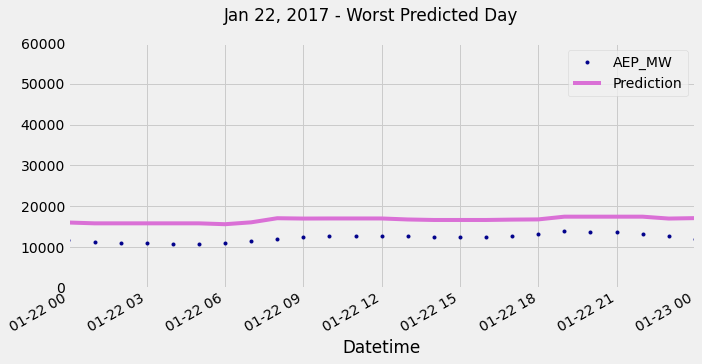

In [152]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = AEP_all[['AEP_MW', 'Prediction']].plot(ax=ax, style=['.','-'], color=[colors[0], colors[4]])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='01-22-2017', upper='01-23-2017')
plot = plt.suptitle('Jan 22, 2017 - Worst Predicted Day')

In [117]:
error_by_day.sort_values('abs_error', ascending=True).head(10)

AEP_MW    Prediction       error   abs_error
year month dayofmonth                                                    
2017 11    8           14602.750000  14602.919922   -0.169474  203.321248
     10    28          12723.833333  12744.483398  -20.650431  214.592570
2018 6     23          14103.291667  14031.885742   71.405680  256.993490
     4     28          12237.583333  12252.085938  -14.502563  259.252157
2015 9     30          13556.583333  13707.728516 -151.145549  264.775920
2017 4     1           12569.208333  12430.785156  138.423665  267.845052
     11    16          14938.958333  14918.449219   20.509603  279.187012
2016 12    12          15836.333333  15871.387695  -35.054525  283.551107
     3     5           14801.166667  14795.866211    5.300618  290.299398
     12    2           15458.250000  15604.341797 -146.091756  291.837443

## Best Predicted Day

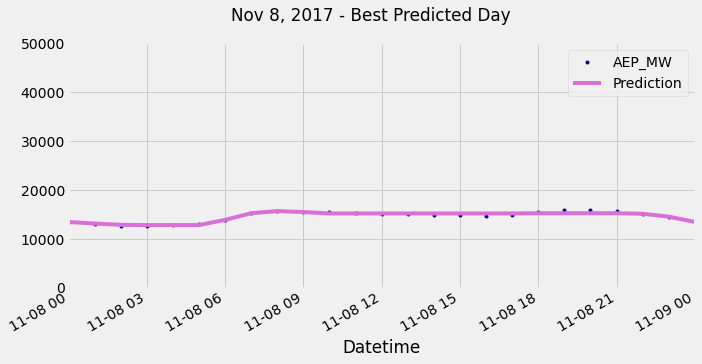

In [119]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = AEP_all[['AEP_MW', 'Prediction']].plot(ax=ax, style=['.','-'], color=[colors[0], colors[4]])
ax.set_ylim(0, 50000)
ax.set_xbound(lower='11-08-2017', upper='11-09-2017')
plot = plt.suptitle('Nov 8, 2017 - Best Predicted Day')